# DACON

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
cd /content/gdrive/My Drive/dacon/fashion_mnist

/content/gdrive/My Drive/dacon/fashion_mnist


In [ ]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,44,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,235,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,2,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,184,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = np.array(train.drop('label', axis = 1), dtype = 'float32')
y = train.label
target = np.array(test, dtype='float32')

In [ ]:
X /= 255
target /= 255

6번 클래스 의류


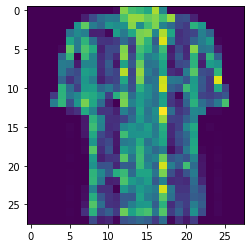

In [ ]:
image = X[2020,:].reshape(28,28)
print(f'{int(y[2020])}번 클래스 의류')
plt.imshow(image)
plt.show()

In [ ]:
X = X.reshape(-1, 28,28,1)
target = target.reshape(-1, 28,28,1)

In [ ]:
np.random.seed(120)

In [ ]:
skf = StratifiedKFold(n_splits = 15, random_state = 120, shuffle = True)

In [ ]:
reLR = ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.4)
es = EarlyStopping(patience = 5, verbose=1, monitor = 'val_acc', mode = 'max')

sub_pred = np.zeros((test.shape[0], 10))

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
  print('=' * 25)
  print(f'{i + 1}번째 학습 FOLD 학습 시작')
  tr_x, tr_y = X[tr_idx], y[tr_idx]
  val_x, val_y = X[val_idx], y[val_idx]

  mc = ModelCheckpoint(f'cv_study{i + 1}.h5',save_best_only=True, verbose=1, monitor = 'val_acc', mode = 'max', save_weights_only=True)

  model = Sequential()
  model.add(Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(10,activation='softmax'))
  model.compile(tfa.optimizers.RectifiedAdam(0.003),loss='sparse_categorical_crossentropy', 
               metrics=['acc'])

  history = model.fit(tr_x, tr_y, epochs = 1000,
                      validation_data = (val_x, val_y), callbacks = [es, mc, reLR])

  model.load_weights(f'cv_study{i + 1}.h5')

  pred = model.predict(target) / 15
  sub_pred += pred
  print(f'{i + 1}번째 학습 FOLD 학습 완료\n')

1750/1750 [==============================] - 29s 17ms/step - loss: 0.1712 - acc: 0.9393 - val_loss: 0.1827 - val_acc: 0.9325

Epoch 00016: val_acc did not improve from 0.94025
Epoch 17/1000
1750/1750 [==============================] - 29s 17ms/step - loss: 0.1666 - acc: 0.9415 - val_loss: 0.1826 - val_acc: 0.9348

Epoch 00017: val_acc did not improve from 0.94025

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.001200000010430813.
Epoch 00017: early stopping
6번째 학습 FOLD 학습 완료

7번째 학습 FOLD 학습 시작
Epoch 1/1000
1750/1750 [==============================] - 35s 17ms/step - loss: 1.1587 - acc: 0.6085 - val_loss: 0.3750 - val_acc: 0.8615

Epoch 00001: val_acc improved from -inf to 0.86150, saving model to cv_study7.h5
Epoch 2/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.4224 - acc: 0.8487 - val_loss: 0.3021 - val_acc: 0.8875

Epoch 00002: val_acc improved from 0.86150 to 0.88750, saving model to cv_study7.h5
Epoch 3/1000
1750/1750 [======================

KeyError: ignored

In [ ]:
submission['label'] = [np.argmax(x) for x in sub_pred]

In [ ]:
submission.to_csv('cv_study.csv', index = False)